In [1]:
!pwd

/home/users/h/henrymi2/jupyecke/noisepy/dvv_stretching


In [1]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import dvv_module
import numpy as np
import os
from obspy import UTCDateTime
import datetime
from datetime import datetime

In [2]:
"""
Calculate dv/v with stretching method
Takes as input a npy file containing:
CCdata: 3D array containing substacks (window time along rows, lag time along columns)
tlag: Lag time
times: timestamp of subwindows
sampling_rate: sampling rate in Hz
fmin, fmax: frequency of bandpass filter applied to CCdata
comp: component
maxlag: maximum lag time
"""

""" Define parameters"""
output_dir = "./stretching/"  # for fig
input_file = "../../data/msnoise_v1/stack2npy/CH_BALST_CH_BOURR_comp_ZZ_filt0.1_1.0_stack021.npy"

# Define reference stack start-end time
tref_start_str = "2019-12-21"
tref_end_str = "2020-03-19"
tref_start = np.datetime64(tref_start_str)
tref_end = np.datetime64(tref_end_str)

# parameters for stretching method
dvv_max = 4/100    # absolute bound for the velocity variation; example: dv=0.03 for [-3,3]% of relative velocity change ('float')
nbtrial = 100      # number of increment of dt [-epsilon,epsilon] for the streching
cc_thresh = 0.1

# Define lag time window for dv/v analysis
vmin = 1.5 # minimum group velocity km/s
dist = 35.68595257075233 # interstation distance in km
lwin = 30   # length of window in s
twin = [int(1.5*dist/vmin), int(1.5*dist/vmin) + lwin]
# twin = [25, 40]
dpi=300

Station pair: CH.BALST - CH.BOURR


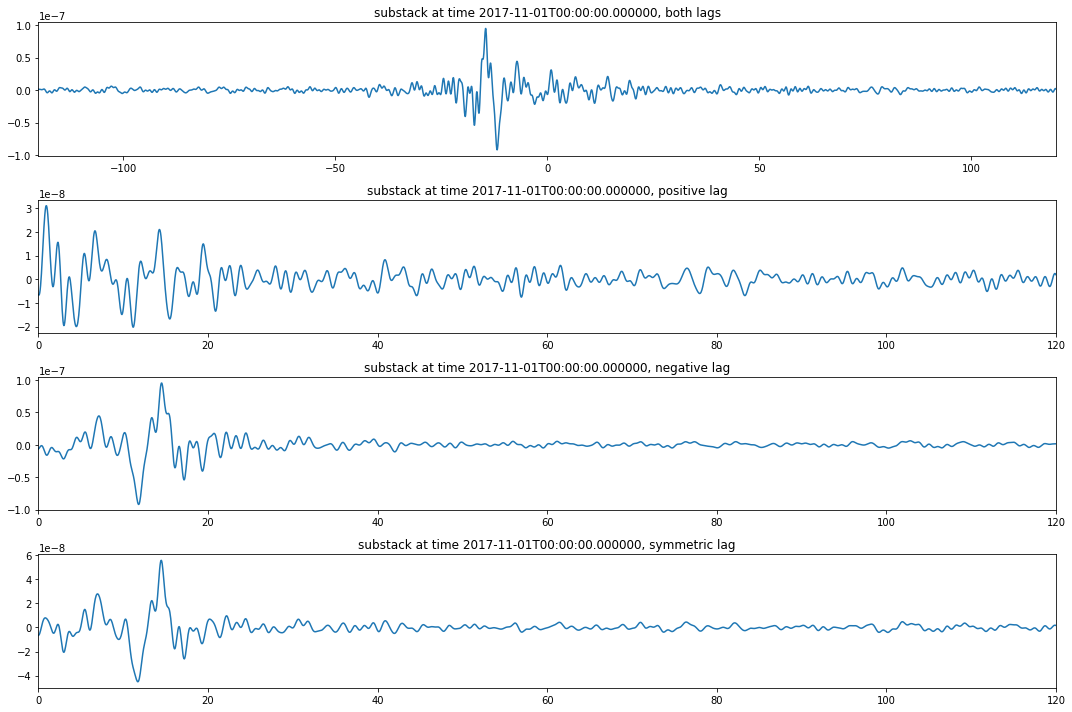

In [3]:
""" Extract data from npy and prepare it"""

# Get station names from file name
dum = os.path.split(input_file)[1].split("_stacks")[0].split("_")
sta1 = f"{dum[0]}.{dum[1]}"
sta2 = f"{dum[2]}.{dum[3]}"
print(f"Station pair: {sta1} - {sta2}")

# Read file
data = np.load(input_file, allow_pickle=True)
ndata = data["CCdata"].T
tlag_all = data["tlag"]
timestamp = data["times"].astype(np.datetime64)
sampling_rate = data["sampling_rate"]
fmin   = data["fmin"]
fmax   = data["fmax"]
comp   = data["comp"]
maxlag = data["maxlag"]
stack  = data["stack"]

# Define new substack length and step
stacklen_new = np.timedelta64(int(stack), "D") #5
step = np.timedelta64(1, "D")

#dist = data["dist"]
npts_all = ndata.shape[1]
npts = npts_all//2
tlag = tlag_all[npts:]
ndata_pos = ndata[:, npts:]  # positive lag
ndata_neg = np.fliplr(ndata[:, :npts + 1])  # negative lag
ndata_sym = np.mean(np.vstack((ndata_pos[np.newaxis], ndata_neg[np.newaxis])), axis=0)
twin_indx = np.where((tlag >= np.min(twin)) & (tlag < np.max(twin)))[0]
npts_win = len(twin_indx)

#Plot positive, negative and symmetric lags for 1st row
plot_lags = True
if plot_lags == True:
    fig, ax = plt.subplots(4, 1, figsize=(15, 10))
    ix = 0
    ax[0].plot(tlag_all, ndata[ix, :])
    ax[0].set_title(f"substack at time {timestamp[0]}, both lags")
    ax[0].set(xlim=(-maxlag,maxlag))
    ax[1].plot(tlag, ndata_pos[ix, :])
    ax[1].set_title(f"substack at time {timestamp[0]}, positive lag")
    ax[2].plot(tlag, ndata_neg[ix, :])
    ax[2].set_title(f"substack at time {timestamp[0]}, negative lag")
    ax[3].plot(tlag, ndata_sym[ix, :])
    ax[3].set_title(f"substack at time {timestamp[0]}, symmetric lag")
    for a in ax[1:]:
        a.set(xlim=(0,tlag[-1]))
    plt.tight_layout()
    plt.show()

# Get reference stack
iref = np.where((timestamp > tref_start) & (timestamp < tref_end))[0]
refstack = np.mean(ndata[iref, :], axis=0)
refstack_pos = np.mean(ndata_pos[iref, :], axis=0)
refstack_neg = np.mean(ndata_neg[iref, :], axis=0)
refstack_sym = np.mean(ndata_sym[iref, :], axis=0)

# Change substack length
_, ndata = dvv_module.change_substack_length(timestamp, ndata, stacklen_new, step, dt=1/sampling_rate)
_, ndata_sym = dvv_module.change_substack_length(timestamp, ndata_sym, stacklen_new, step, dt=1/sampling_rate)
_, ndata_pos = dvv_module.change_substack_length(timestamp, ndata_pos, stacklen_new, step, dt=1/sampling_rate)
timestamp, ndata_neg = dvv_module.change_substack_length(timestamp, ndata_neg, stacklen_new, step, dt=1/sampling_rate)

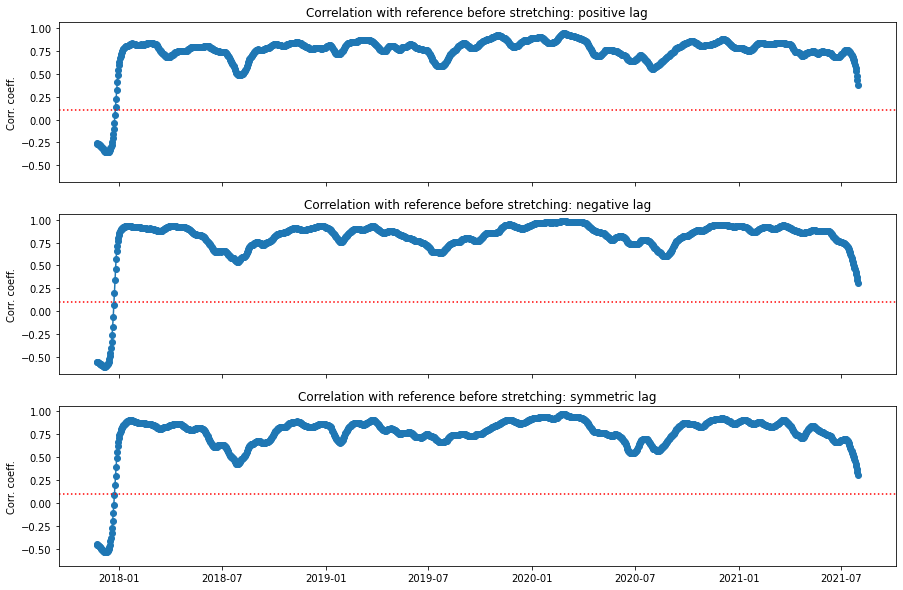

In [4]:
# Get correlation coefficient between substack and reference (before stretching)
nwin = ndata_sym.shape[0]
cc_pos = np.zeros(shape=(nwin,), dtype=np.float32)
cc_neg = np.zeros(shape=(nwin,), dtype=np.float32)
cc_sym = np.zeros(shape=(nwin,), dtype=np.float32)
for iwin in range(nwin):
    cc_pos[iwin] = np.corrcoef(refstack_pos[twin_indx], ndata_pos[iwin, twin_indx])[0, 1]
    cc_neg[iwin] = np.corrcoef(refstack_neg[twin_indx], ndata_neg[iwin, twin_indx])[0, 1]
    cc_sym[iwin] = np.corrcoef(refstack_sym[twin_indx], ndata_sym[iwin, twin_indx])[0, 1]

fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(15,10))
ax[0].plot(timestamp, cc_pos, marker="o")
ax[0].axhline(cc_thresh, c="r", ls=":")
#ax[0].axvline(EQtime._get_datetime(), c="k", ls="--")
ax[0].set_title("Correlation with reference before stretching: positive lag")
ax[1].plot(timestamp, cc_neg, marker="o")
ax[1].axhline(cc_thresh, c="r", ls=":")
#ax[1].axvline(EQtime._get_datetime(), c="k", ls="--")
ax[1].set_title("Correlation with reference before stretching: negative lag")
ax[2].plot(timestamp, cc_sym, marker="o")
ax[2].axhline(cc_thresh, c="r", ls=":")
#ax[2].axvline(EQtime._get_datetime(), c="k", ls="--")
ax[2].set_title("Correlation with reference before stretching: symmetric lag")
for a in ax:
    a.set(ylabel="Corr. coeff.")
plt.show()

In [5]:
%whos  

Variable         Type           Data/Info
-----------------------------------------
UTCDateTime      type           <class 'obspy.core.utcdatetime.UTCDateTime'>
a                Axes           Axes(0.125,0.125;0.775x0.222059)
ax               ndarray        3: 3 elems, type `object`, 24 bytes
cc_neg           ndarray        1348: 1348 elems, type `float32`, 5392 bytes
cc_pos           ndarray        1348: 1348 elems, type `float32`, 5392 bytes
cc_sym           ndarray        1348: 1348 elems, type `float32`, 5392 bytes
cc_thresh        float          0.1
comp             ndarray        : 1 elems, type `<U2`, 8 bytes
data             NpzFile        <numpy.lib.npyio.NpzFile <...>object at 0x14ed3e65bc10>
datetime         type           <class 'datetime.datetime'>
dist             float          35.68595257075233
dpi              int            300
dum              list           n=9
dvv_max          float          0.04
dvv_module       module         <module 'dvv_module' from<...>tretchi

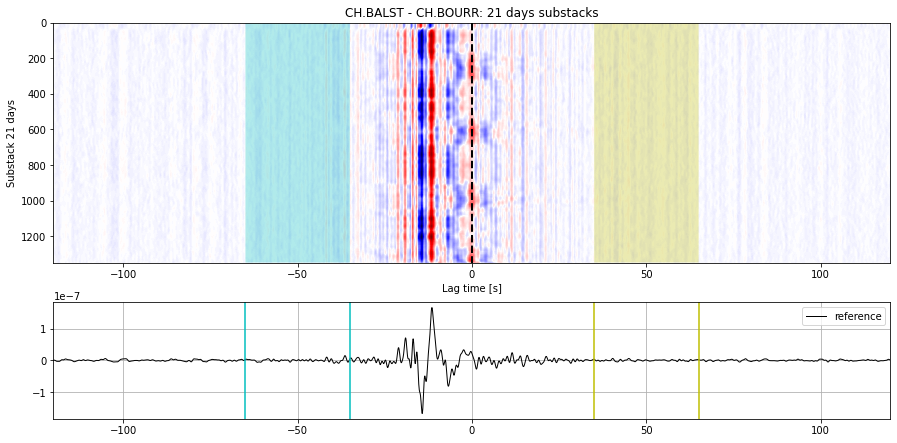

In [6]:
""" Plot cross correlation and the time window """

plt.figure(figsize=(15,15))
ax0 = plt.subplot(311)

# 2D waveform matrix
ax0.matshow(ndata,cmap='seismic',extent=[tlag_all[0],tlag_all[-1],nwin,0],aspect='auto')
ax0.set(xlabel="Lag time [s]", ylabel=f"Substack {str(stacklen_new)}" ,title=f"{sta1} - {sta2}: {str(stacklen_new)} substacks")
ax0.plot([0,0],[0,nwin],'k--',linewidth=2)

# Shade the coda part
nwin_indx = np.where((tlag_all <= -np.min(twin)) & (tlag_all > -np.max(twin)))[0] # negative lag time indices for dvv window
pwin_indx = np.where((tlag_all >= np.min(twin)) & (tlag_all < np.max(twin)))[0] # positive lag time indices for dvv window
ax0.fill(np.concatenate((tlag_all[nwin_indx],np.flip(tlag_all[nwin_indx],axis=0)),axis=0), \
    np.concatenate((np.ones(len(nwin_indx))*0,np.ones(len(nwin_indx))*nwin),axis=0),'c', alpha=0.3,linewidth=1)
ax0.fill(np.concatenate((tlag_all[pwin_indx],np.flip(tlag_all[pwin_indx],axis=0)),axis=0), \
    np.concatenate((np.ones(len(nwin_indx))*0,np.ones(len(nwin_indx))*nwin),axis=0),'y', alpha=0.3)
ax0.xaxis.set_ticks_position('bottom')

# reference waveform
ax1 = plt.subplot(613)
ax1.plot(tlag_all,refstack,'k-',linewidth=1)
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.grid(True)
ax1.legend(['reference'],loc='upper right')
ax1.axvline(tlag_all[nwin_indx[0]], c="c")
ax1.axvline(tlag_all[nwin_indx[-1]], c="c")
ax1.axvline(tlag_all[pwin_indx[0]], c="y")
ax1.axvline(tlag_all[pwin_indx[-1]], c="y")

plt.show()
plt.close()

In [8]:
""" Apply the stretching function 
def stretching(ref, cur, dv_range, nbtrial, para):
    This function compares the Reference waveform to stretched/compressed current waveforms to get the relative seismic velocity variation (and associated error).
    It also computes the correlation coefficient between the Reference waveform and the current waveform.

    PARAMETERS:
    ----------------
    ref: Reference waveform (np.ndarray, size N)
    cur: Current waveform (np.ndarray, size N)
    dv_range: absolute bound for the velocity variation; example: dv=0.03 for [-3,3]% of relative velocity change ('float')
    nbtrial: number of stretching coefficient between dvmin and dvmax, no need to be higher than 100  ('float')
    para: vector of the indices of the cur and ref windows on wich you want to do the measurements 
    (np.ndarray, size tmin*delta:tmax*delta)
    For error computation, we need parameters:
        fmin: minimum frequency of the data
        fmax: maximum frequency of the data
        tmin: minimum time window where the dv/v is computed
        tmax: maximum time window where the dv/v is computed
    RETURNS: dv, error, cc, cdp
    ----------------
    dv: Relative velocity change dv/v (in %)
    error: Errors in the dv/v measurements based on Weaver et al (2011), On the precision of noise-correlation interferometry, Geophys. J. Int., 185(3)
    cc: correlation coefficient between the reference waveform and the best stretched/compressed current waveform
    cdp: correlation coefficient between the reference waveform and the initial current waveform    

    Note: The code first finds the best correlation coefficient between the Reference waveform and the stretched/compressed current waveform among the "nbtrial" values.
    A refined analysis is then performed around this value to obtain a more precise dv/v measurement .
"""

param  = {
    'freq':[fmin,fmax], # frequency of bandpass filter applied to stacks
    'twin': twin,  # start-end of time window in s
    'dt': 1/sampling_rate,  # sampling interval in s
    't': tlag  # vector of lag time
}

# Allocate matrix for dvv and its uncertainty
dvv_stretch = np.empty(shape=(nwin,6),dtype=np.float32)
ccafter_stretch = np.empty(shape=(nwin,3),dtype=np.float32)

dvv_stretch[:] = np.nan
ccafter_stretch[:] = np.nan

# loop through each substack window
for iwin in range(nwin):
    
    # symmetric, casual and acausal lags for both ref and current waveform
    pcur = ndata_pos[iwin,twin_indx]   # substack, positive lag
    ncur = ndata_neg[iwin,twin_indx]   # substack, negative lag
    scur = ndata_sym[iwin,twin_indx]   # substack, symmetric lag
    pref = refstack_pos[twin_indx]  # reference, positive lag
    nref = refstack_neg[twin_indx]  # reference, negative lag
    sref = refstack_sym[twin_indx]  # reference, symmetric lag
    
    if cc_pos[iwin] >= cc_thresh: # Only keep substack if correlation coefficient before stretching above threshold
        dvv, error,ccafter_pos,cdp_pos = dvv_module.stretching_vect(pref,pcur,dvv_max,nbtrial,param)        
        #print(f"window {timestamp[iwin]} sym lag: dv/v = {dvv:.2f}, error = {error:.2f}")
        # print(f"window {timestamp[iwin]} positive lag: dv/v = {dvv:.2f}, error = {error:.2f}")
        dvv_stretch[iwin,0],dvv_stretch[iwin,1] = dvv, error
        ccafter_stretch[iwin,0] = ccafter_pos
    if cc_neg[iwin] >= cc_thresh:
        dvv, error,ccafter_neg,cdp_neg = dvv_module.stretching_vect(nref,ncur,dvv_max,nbtrial,param)        
        #print(f"window {timestamp[iwin]} pos lag: dv/v = {dvv:.2f}, error = {error:.2f}")
        # print(f"window {timestamp[iwin]} negative lag: dv/v = {dvv:.2f}, error = {error:.2f}")
        dvv_stretch[iwin,2],dvv_stretch[iwin,3] = dvv, error        
        #ccafter_stretch[iwin,1] = ccafter_pos
        ccafter_stretch[iwin,1] = ccafter_neg
    if cc_sym[iwin] >= cc_thresh:
        dvv, error,ccafter_sym,cdp_sym = dvv_module.stretching_vect(sref,scur,dvv_max,nbtrial,param)        
        #print(f"window {timestamp[iwin]} neg lag: dv/v = {dvv:.2f}, error = {error:.2f}")
        # print(f"window {timestamp[iwin]} sym lag: dv/v = {dvv:.2f}, error = {error:.2f}")
        dvv_stretch[iwin,4],dvv_stretch[iwin,5] = dvv, error        
        ccafter_stretch[iwin,2] = ccafter_pos
        #ccafter_stretch[iwin,2] = ccafter_sym
    #print(dvv_stretch[iwin,:])

NameError: name 'ccafter_pos' is not defined

In [ ]:
t = np.array(timestamp).astype(datetime)
fig, axs = plt.subplots(3,1,sharex=False, sharey=False, figsize=(2*15,2*8))
fig.suptitle(f'Station pair: {sta1} - {sta2}', fontsize=22)
# axs[0].plot(t, dvv_stretch[:,5], marker="o")
axs[0].errorbar(t, dvv_stretch[:,4], yerr=dvv_stretch[:,5], c="b", capsize=2)
axs[0].set_title(f"dv/v for symmetric window")
# axs[1].plot(t, dvv_stretch[:,0], marker="o")
axs[1].errorbar(t, dvv_stretch[:,0], yerr=dvv_stretch[:,1], c="b", capsize=2)
axs[1].set_title(f"dv/v for causal window") #[positive lag]
# axs[2].plot(t, dvv_stretch[:,2], marker="o")
axs[2].errorbar(t, dvv_stretch[:,2], yerr=dvv_stretch[:,3], c="b", capsize=2)
axs[2].set_title(f"dv/v for acausal window") #[negative lag]
for ax in axs:
    # locator = mdates.HourLocator(interval=100)
    # locator.MAXTICKS = 2000
    # ax.xaxis.set_major_locator(locator)
    ax.set(ylabel="dv/v [%]")    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # ax.tick_params(which='major', length=10)
    ax.tick_params(which='major')
    fmt_month = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(fmt_month)
    ax.xaxis.grid(True, which='minor')
    #ax.axvline(EQtime._get_datetime(), c="k", ls="--")
    ax.axhline(0, c="k", ls="-")
plt.show()
plt.close()

In [ ]:
""" Symmetric lag plot """

plt.figure(figsize=(15,25))
ax0= plt.subplot(612)

# 2D waveform matrix
ax0.matshow(ndata_sym,cmap='seismic',extent=[tlag[0],tlag[-1],nwin,0],aspect='auto')
#ax0.set(xlabel="Lag time [s]", ylabel=f"Substack {str(stacklen_new)}") #, title=f"{sta1}-{sta2} {str(stacklen_new)} substacks")
ax0.set_xlabel("Lag time [s]", size=22)
ax0.set_ylabel(f"Substack days", size=22) #"{str(stacklen_new)}", size=22)
ax0.set_title(f"{sta1}-{sta2} {str(comp)} Components. {str(stacklen_new)} substacks. Filter {str(fmin)} - {str(fmax)} Hz", size=22)
ax0.tick_params(axis='y', labelcolor='black', labelsize='20')
ax0.tick_params(axis='x', labelcolor='black', labelsize='20')
ax0.plot([0,0],[0,nwin],'k--',linewidth=2)
# shade the coda part
pwin_indx = np.where((tlag >= np.min(twin)) & (tlag < np.max(twin)))[0] # positive lag time indices for dvv window
ax0.fill(np.concatenate((tlag[pwin_indx],np.flip(tlag[pwin_indx],axis=0)),axis=0), \
    np.concatenate((np.ones(len(nwin_indx))*0,np.ones(len(nwin_indx))*nwin),axis=0),'y', alpha=0.3)
ax0.xaxis.set_ticks_position('bottom')
ax0.axvline(dist/vmin, c="k", ls=":", lw="3")
#ax0.legend([f"Reference stack: {tref_start_str} to {tref_end_str}", f"Direct arrival v={vmin:.1f} km/s", "analysis window"],loc='upper right')

# reference waveform
ax1 = plt.subplot(613)
ax1.plot(tlag,refstack_sym,'k-',linewidth=1)
#ax1.set_title(f"Reference stack", size=22)
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='black', labelsize='20')
ax1.tick_params(axis='x', labelcolor='black', labelsize='20')
ax1.axvline(dist/vmin, c="r", ls=":")
ylims = ax1.get_ylim()
ax1.fill(np.concatenate((tlag[pwin_indx],np.flip(tlag[pwin_indx],axis=0)),axis=0), \
    np.concatenate((np.ones(len(nwin_indx))*ylims[0],np.ones(len(nwin_indx))*ylims[1]),axis=0),'y', alpha=0.3)
ax1.legend([f"Reference stack: {tref_start_str} to {tref_end_str}", f"Direct arrival v={vmin:.1f} km/s", "analysis window"],loc='upper right', fontsize="14")

#ax1.axvline(tlag[pwin_indx[0]], c="y")
#ax1.axvline(tlag[pwin_indx[-1]], c="y")


# Plot dv/v
ax2 = plt.subplot(614) #614
ax2.errorbar(t[45:], dvv_stretch[45:,4], yerr=dvv_stretch[45:,5], c="b", capsize=2)
ax2.set_title(f"dv/v for symmetric window", size=22)
ax2.set_ylabel("dv/v [%]", size=22)     
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.tick_params(which='major', labelsize='20')
fmt_month = mdates.MonthLocator()
ax2.xaxis.set_minor_locator(fmt_month)
ax2.xaxis.grid(True, which='minor')
ax2.axhline(0, c="k", ls="-")
plt.setp(ax2.get_xticklabels(), rotation=30, ha='right')

# CC after stretching
ax3 = plt.subplot(615) # (615)
ax3.plot(t, ccafter_stretch[:,2], marker="o")
ax3.set_title(f"CC after stretching", size=22)
ax3.tick_params(axis='y', labelcolor='black', labelsize='20')
ax3.tick_params(axis='x', labelcolor='black', labelsize='20')
ax3.set_xlabel('Date', size='22', color='black')
ax3.set_ylabel("CC coeff", size=18)
fmt_month = mdates.MonthLocator()
ax3.xaxis.set_minor_locator(fmt_month)
ax3.xaxis.grid(True, which='minor')
plt.setp(ax3.get_xticklabels(), rotation=30, ha='right')

output_file = os.path.join(output_dir, f"{sta1}_{sta2}_stretching_{str(comp)}_{str(stacklen_new).replace(' ','')}\
_symlag_Filt{str(fmin)}_{str(fmax)}.pdf")
print(output_file)
plt.tight_layout(pad=0.5)
plt.savefig(output_file, format="PDF", dpi=dpi, bbox_inches='tight')
plt.show()
plt.close()